# Fine-tuning BERT for Sentiment Analysis On My Anime List Reviews
[![Portfolio](https://img.shields.io/badge/Portfolio-chriskhanhtran.github.io-blue?logo=GitHub)](https://chriskhanhtran.github.io/) 코드 참조 및 개조

# A - Introduction

해당 프로젝트는 MAL(My Anime List)이라는 애니메이션 평점 사이트 댓글들을 활용하여 BERT모델을 Fine Tuning한 프로젝트이다. 크롤링의 간편성과 레이블링을 하는 시간을 절약하기 위해서 압도적으로 부정적인 평들이 많은 "약속의 네버랜드 시즌2(The Promised Neverland Season 2, 이후 네버랜드)"과 압도적으로 긍정적인 평들이 많은 "강철의 연금술사:브라더후드(Full Metal Alchemist: Brotherhood, 이후 강연)"을 활용하기로 했다.

강연의 댓글들을 읽다보면 거의 모든 것들이 긍정의 표시이기 때문에 모든 sentiment의 label을 긍정인 1로 하였고, 네버랜드는 안타깝게도 거의 모든 댓글이 완전 부정이거나 약한 부정을 하고 있는 것으로 보아 모든 sentiment의 label을 0으로 조정하였다. 

데이터는 MAL에서 댓글을 크롤링하였고, csv파일로 정리하였다. 

HuggingFace의 transformers 라이버러리를 활용하여 사전학습된 BERT모델을 FIne Tuning하였고 일반적인 TF-IDF Vectorizer와 Naive Bayes 분류 알고리즘과 성능을 비교하였다.


**Reference**:

To understand **Transformer** (the architecture which BERT is built on) and learn how to implement BERT, I highly recommend reading the following sources:

- [The Illustrated BERT, ELMo, and co.](http://jalammar.github.io/illustrated-bert/): A very clear and well-written guide to understand BERT.
- [The documentation of the `transformers` library](https://huggingface.co/transformers/v2.2.0/index.html)
- [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) by [Chris McCormick](http://mccormickml.com/): A very detailed tutorial showing how to use BERT with the HuggingFace PyTorch library.



# B - Setup

## 1. Load Essential Libraries(필수적인 라이브러리를 가져온다)

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset(데이터셋을 준비해온다)
### 원래 프로젝트에서는 Airline complaint 데이터셋을 이용하여 튜닝하였으나, 이번 프로젝트는 자체적으로 크롤링해온 데이터를 활용하고자 한다.

### 2.2. Load Train Data
Fine tuning에 학습될 데이터셋은 두개가 있다. 하나는 모두 긍정으로 표기되어 있는 강연데이터셋과 다른 하나는 모두 부정으로 표기되어 있는 네버렌드 데이터셋이다. 

review의 칼럼을 활용하여 학습을 할것이고, 긍정인지 부정인지의 여부(즉 종속변수)는 sentiment칼럼을 활용할 것이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # Load data and set labels
data_review = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/promised_neverland.csv')

# Display 5 random samples
data_review = data_review.rename(columns={'Unnamed: 0': 'review_id'})
data_review['sentiment'] = 0
len(data_review)
## 약속의 네버랜드 댓글 수는 총 274개이다.

274

In [ ]:
data_review2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fma.csv')

# Display 5 random samples
data_review2 = data_review2.rename(columns={'Unnamed: 0': 'review_id'})
data_review2['sentiment'] = 1
len(data_review2)
## 강철의 연금술사의 댓글 수는 380개이다.

380

In [ ]:
data = pd.concat([data_review, data_review2], axis=0).reset_index(drop=True)
data.sample(5)
## 두 데이터셋을 합침

,review_id,review,sentiment
43,43,Rushed story and...,0
394,120,This series is o...,1
81,81,I couldnt wait f...,0
120,120,Welp Where do I ...,0
607,333,Overrated Just a...,1


합쳐진 데이터셋을 학습데이터와 성능을 평가 할 수 있는 데이터셋으로 9:1 비율로 나눈다. 

In [ ]:
from sklearn.model_selection import train_test_split

X = data.review.values
y = data.sentiment.values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

### 2.3. Load Test Data
test data를 준비한다. "무직전생(Mushoku Tensei)" 리뷰들이 부정적인 리뷰와 긍정적인 리뷰들이 적절히 섞여있어 선정하게 됨. 학습된 모델을 바탕으로 다음 데이터셋에 나와있는 리뷰들의 감성분석을 시행할 것이다. test data의 크기는 352개이다.

In [ ]:
# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mushoku.csv')
test_data = test_data.rename(columns={'Unnamed: 0': 'review_id'})
# Keep important columns
test_data = test_data[['review_id', 'review']]

# Display 5 samples from the test data
test_data.sample(5)
len(test_data)

352

## 3. Set up GPU for training

구글 콜랩이 제공하는 GPU를 활용하여 학습할 것이다. 파이토치를 활용하여 GPU의 존재여부를 확인한다.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier. BERT모델을 적용하기 전에, 기본적인 TF-IDF벡터화를 통해(카운트 기반의 BOW을 활용한다), 그 후 기본적인 Naive Bayes모델을 활용하여 분류를 해본다. 이는 BERT모델의 성능차이를 보기 위한 비교모델이다.


## 1. Data Preparation

### 1.1. Preprocessing

BOW기법으로 벡터화를 진행할 경우, 단어의 출현 빈도에 따라 벡터화하기 때문에, 문서의 의미에 기여하지 않는 불용어(a, the와 같은 관사)들은 제거해두는 것이 좋다. 이를 위해 nltk 패키지 내재되어있는 불용어 사전을 활용할 것이다. 또한, 특수 기호들 및 띄어쓰기를 제거하도록 할 것이다. 

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.2. TF-IDF Vectorizer

TF-IDF벡터화 기법은 한 문서에서 사용되는 단어가 다른 문서에 비해서 상대적인 중요도를 비교한 것을 바탕으로 벡터화하는 카운트기반의 벡터화기법이다. Naive Bayes모델에 데이터를 학습시키기 전, TF-IDF방법으로 벡터화를 하는 과정을 거친다. scikitlearn의 TFidfVectorizer를 활용한다.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

CPU times: user 27.7 s, sys: 3.14 s, total: 30.8 s
Wall time: 30.8 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

Cross validation(교차검증) 및 AUC Score(클수록 정확도가 높다)를 평가 수치로 하여 이를 극대화 할 수 있도록 hyperparameter를 조정하고자 한다.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Naive Bayes의 `MultinominalNB`는 hyperparameter가 알파 하나이다. 이를 최적의 알파값을 찾기 위해 알파를 조금씩 조정해간다. 

Best alpha:  1.0


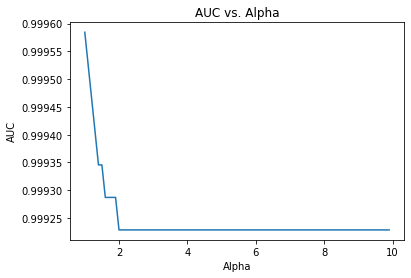

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

Validation Set를 통해 성능을 평가하기 위해 AUC아 Accuracy Score를 활용한다.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

이렇게 TF-IDF와 Naive Bayes모델을 활용하여 나온 성능은 **74.24%**이다. 이 수치는 BERT를 활용한 모델이 넘어야 할 베이스라인으로 잡을 것이다.
 

AUC: 0.9897
Accuracy: 74.24%


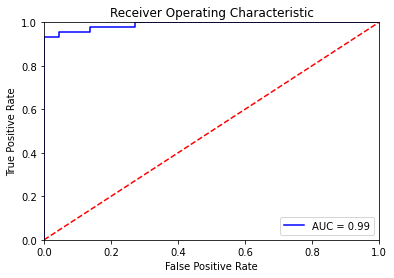

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_test)

# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

Hugging Face의 Library를 활용하면, Pytorch 프레임워크로 이용할 수 있는 BERT, GPT 등의 모델및 사전학습된 가중치들을 활용할 수 있다.

In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 7.8MB/s 
     |████████████████████████████████| 5.6MB 8.6MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 890kB 59.3MB/s 
     |████████████████████████████████| 1.2MB 46.2MB/s 
     |████████████████████████████████| 7.4MB 49.3MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=df7158b62d0846a52bae9886d87d81e65948461e597015b70d42e93c2e33b9fc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.20.44 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


## 2. Tokenization and Input Formatting

문장들을 토큰화하기 전에 특수기호 제거 및 쓸데 없는 띄어쓰기를 제거하도록 한다.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:                                The Promised Neverland nd Season is a brilliant achievement of Japanese Television It is a series that has no reason to exist other than to profit off of unsuspecting fans of the first season This is the spiritual successor to Tokyo Ghoul Root Aanother anime original sequel that attempted to inflict as much severe pain and suffering on the manga fans as possible Except at least that blatant marketing scheme had semidecent audiovisuals This sequel follows Female Kirito previously known as Emma Similar to Kirito Emma is also the most powerful player in the video game Rather than using a sword she has the power                  of plot armor to protect her from any danger Getting chased by a demon She can outrun it Armed soldiers cant kill demons with guns Shell kill it with a bow  arrow Instead of getting followed around by a harem Female Kirito has a bunch of children that go along with anything she says They have names but dont worryyou wont rem

### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,(텍스트를 정해진 토큰단위로 나눈다)

(2) add the special `[CLS]` and `[SEP]` tokens, and([CLS], 및 [SEP] 토큰을 추가한다)

(3) convert these tokens into indexes of the tokenizer vocabulary,(토큰화 어휘록에 내재되어 있는 인덱스로 전환한다)

(4) pad or truncate sentences to max length, and(max length(최대길이)로 맞추기 위해 문장들에 패딩을 추가하거나, 길이를 줄인다)

(5) create attention mask.(어텐션 마스크를 추가한다(예측해야 할 다음 단어들을 마스킹한다))






In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

문장의 최대길이를 설정해야 한다. 해당 리뷰들은 애니메이션에 대한 감상평을 굉장히 상세하게 기재하여서, 한문장 한문장의 길이가 모델에서 수용할 수 있는 최대길이를 거뜬히 넘어가는 경향이 있다(최대길이 512)) 단어들이 임베딩 될때 전체적인 의미가 내포되지 않을 가능성도 있을 듯하다.

In [ ]:
# Concatenate train data and test data
all_review = np.concatenate([data.review.values, test_data.review.values])

# Encode our concatenated data
encoded_review = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_review]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_review])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (974 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (955 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Max length:  3812


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Original:                                The Promised Neverland nd Season is a brilliant achievement of Japanese Television It is a series that has no reason to exist other than to profit off of unsuspecting fans of the first season This is the spiritual successor to Tokyo Ghoul Root Aanother anime original sequel that attempted to inflict as much severe pain and suffering on the manga fans as possible Except at least that blatant marketing scheme had semidecent audiovisuals This sequel follows Female Kirito previously known as Emma Similar to Kirito Emma is also the most powerful player in the video game Rather than using a sword she has the power                  of plot armor to protect her from any danger Getting chased by a demon She can outrun it Armed soldiers cant kill demons with guns Shell kill it with a bow  arrow Instead of getting followed around by a harem Female Kirito has a bunch of children that go along with anything she says They have names but dont worryyou wont rem

### 2.2. Create PyTorch DataLoader

DataLoader를 활용하여 학습연산의 속도를 높일 수 있도록 설정한다.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT의 기본적인 구조는 12개의 transformer층으로 구성되어 있고 각 transformer층은 토큰화된 임베딩을 입력값으로 받아서 같은 크기와 같은 갯수의 임베딩을 출력한다. 최종 transformer층에서 나온 출력값은  classifier에 전달될 특징들을 담고 있다.



기본적으로 제공되는 BERT Classifier를 사용 할 수도 있지만 우선 자체적인 Classifier Class을 만들어서 진행을 할 것이다.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 33 µs, sys: 2 µs, total: 35 µs
Wall time: 42 µs


### 3.2. Optimizer & Learning Rate Scheduler

모델의 최적화를 위해서 Optimizer를 도입을 할 것이다. BERT의 저자들은 다음과 같은 hyperparameter를 설정하도록 권한다:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) (AdamW optimizer를 활용하여 모델 최적화를 할 것이다).

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

4번 데이터셋을 통과시켜서(4에포크) 학습을 시킬 것이며, 한번 학습 할 때 마다 교차성능검사를 할 것이다(validation set):

Training:
- Unpack our data from the dataloader and load the data onto the GPU(GPU에 데이터를 연다)
- Zero out gradients calculated in the previous pass(gradient값을 매회 마다 초기화하기)
- Perform a forward pass to compute logits and loss(loss를 측정하기 위해서 전진전파를 실행)
- Perform a backward pass to compute gradients (`loss.backward()`)(gradient값을 측정하기 위해 역전파실행)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"(경사폭증 현상을 막기 위해 최대치를 1로 설정)
- Update the model's parameters (`optimizer.step()`)(parameter를 매회마다 조정)
- Update the learning rate (`scheduler.step()`)(매회마다 학습률을 조정)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass(전진전파)
- Compute loss and accuracy rate over the validation set(손실과 accuracy를 validation set에서 평가한다)



In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, test_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_accuracy = []
    test_loss = []

    # For each batch in our validation set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   18    |   0.637458   |     -      |     -     |   6.44   
----------------------------------------------------------------------
   1    |    -    |   0.637458   |  0.345500  |   95.83   |   6.68   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   18    |   0.270310   |     -      |     -     |   6.26   
----------------------------------------------------------------------
   2    |    -    |   0.270310   |  0.202803  |   93.75   |   6.49   
----------------------------------------------------------------------


Training complete!


### 3.4. Evaluation on Validation Set

 예측 단계에서 softmax layer로 통과시켜 긍/부정의 확률값을 계산한다.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9773
Accuracy: 90.91%


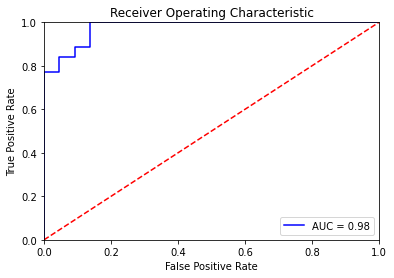

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

AUC값은 0.9773으로 나왔고, Accuracy는 90.91%가 나온다. 일단 수치로만 놓고 봤을때 꽤나 성능이 좋게 나온다. 

### 3.5. Train Our Model on the Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, test_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.516691   |     -      |     -     |   7.10   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.179846   |     -      |     -     |   7.10   
----------------------------------------------------------------------


Training complete!


## 4. Predictions on Test Set

### 4.1. Data Preparation

테스트 데이터에 예측을 할 것인데, 우선 다시 테스트 데이터를 다시 불러올 것이다.



In [ ]:
test_data.sample(5)

,review_id,review
183,183,This review will...
288,288,ANIME OF THE YEA...
54,54,For all the talk...
154,154,About years ago...
136,136,NO SPOILER HERE ...


 `preprocessing_for_bert` 를 활용해서 테스트 데이터를 전처리 한다.

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### 4.2. Predictions

126개의 리뷰가 긍정으로 나왔는데(non-negative) 기준치 확률값을 0.992, 즉 99.2%가 넘는 것들만 선정을 하는 것으로 한다. default threshold인 0.5보다는 월등히 높은 수치이다. 즉, 확실히 긍정으로 판단하는 것들만 긍정으로 삼겠다는 것이다.


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  126


한가지 문제가 발생헀다.... 

In [ ]:
output = test_data[preds==1]
positive_reviews = list(output.sample(20).review)
positive_reviews[7]
#생각보다 성능이 좋지는 않다... 데이터 정제를 좀더 해야 하나? 너무 글이 길어서 그런가?

'                              The Grandfather of Isekai You may have heard on the grapevine about which was the FIRST series to start the whole Isekai fantasy lore and truth be told there have been many series that try to push forward the genre of fanfiction and growing its culture at a time when there was no concrete grouping that allowed authors to run freely of ideas unimaginable And Im here to say that even if Mushoku Tensei regards itself as the pioneer of Naroukei LNs or Syosetu as its more wellknown its definitely the first to bring the wave of what has now become the oversaturated Isekai genre                  with its many genredefining tacticsnot in the easiest ways possible but through luck and persistence via Syosetu Heck even the novelist himself Rifujin no Maganote said so that Mushoku Tensei just borrows similar prospects of web novels that were popular at the time and mashes it all in one package But lets not take the high road too quick and slow down the paces as this

# E - Conclusion

우선 sentiment 분류는 어떤 것들은 잘 분류가 되어있지만, 어떤것들은 잘못 분류가 되어 있다. 이는 당연하게 생각 할 수 있겠지만 데이터를 보는 과정에서 몇가지 문제점이 발견되었다. 또한 해당 프로젝트에서 몇가지 한계점 또한 존재한다.
- 우선 리뷰를 작성한 유저들은 대체적으로 리뷰를 장문의 에세이 형식으로 쓰는 것을 굉장히 좋아한다.따라서 텍스트의 길이가 위의 결과와 같이 엄청나게 늘어나게 된다. 따라서 인간이 읽어도 긍정인지 부정인지도 판별하기가 굉장히 어렵다. 
- 손으로 라벨을 붙이는 시간을 줄이기 위해 압도적으로 긍정인 애니메이션 시리즈와 압도적으로 부정인 시리즈를 선정하여 일괄적으로 라벨을 통일하였는데, 이 과정에서 잘못 라벨링이 되어있을 수가 있다. 따라서 학습 또한 잘 못 됐을 가능성이 있다. 이 점을 보완하기 위해서 시간을 가지고 라벨링을 일일히 할 필요가 있어보인다.
- 시간을 단축하기 위해 몇가지 3개의 애니메이션 시리즈의 리뷰를 클롤링하였지만, 더 다양한 시리즈의 리뷰들을 크롤링하는 것도 좋을 듯하다.